## Programming Exercise 6: Support Vector Machines
#### Author - Rishabh Jain

In [1]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cvxopt, re

%matplotlib inline

from scipy.io import loadmat

#### Learning Resources
1. [SVM Video Lecture (MIT)](https://www.youtube.com/watch?v=_PwhiWxHK8o)
2. [29 to 33 SVM Video Lectures (University of Buffalo)](https://www.youtube.com/watch?v=N4pai7eZW_o&list=PLhuJd8bFXYJsSXPMrGlueK6TMPdHubICv&index=29)
3. [Support Vector Machine Succinctly (PDF)](./Lectures/svm.pdf)


Before solving the programming assignment from the course, let's try to understand the **Maths Behind SVM :**
1. [Maximum Margin Classifier](#Maximum-Margin-Classifier)
2. [Lagrange Multipliers](#Understanding-Lagrange-Multipliers)
3. [Primal and Dual Lagrangian](#Primal-and-Dual-Formulations)
4. [Hard Margin SVM](#Hard-Margin-SVM)
5. [Soft Margin SVM](#Soft-Margin-SVM)
6. [Hypothesis Function](#Hypothesis-Function)
7. [Kernel Trick](#Kernel-Trick)
8. [SVM Implementation using CVXOPT](#SVM-Implementation-using-CVXOPT-Solver)

### Maximum Margin Classifier

For two-class, such as the one shown below, there are lots of possible linear separators. Intuitively, a decision boundary drawn in the middle of the void between data items of the two classes seems better than one which approaches very close to examples of one or both classes. While some learning methods such as the logistic regression find just any linear separator. **The SVM in particular defines the criterion to be looking for a decision surface that is MAXIMALLY far away from any data point**. This distance from the decision surface to the closest data point determines the margin of the classifier.

<img src="images/svm1.PNG" width="380"/>

Let's imagine a vector $\vec{w}$ perpendicular to the margin and an unknown data point $\vec{u}$ which can be on either side of the margin. In order to know whether $\vec{u}$ is on the right or left side of the margin, we will project (Dot product) $\vec{u}$ onto $\vec{w}$.

$$\vec{w}.\vec{u}\geq c$$
$$\boxed{\vec{w}.\vec{u}+b\geq 0}\;\;(1)$$ 

If the projection of $\vec{u}$ plus some constant $b$ is greater than zero, then its a positive sample otherwise its a negative sample.**Eq. (1) is our DECISION RULE**. Here the problem is that we don't know what $w$ and $b$ to use.  

**An unknown sample may be located anywhere inside or outside the margin (i.e. >0 or <0), but if it's a known positive sample $\vec{x_{+}}$ then the SVM decision rule should insist the dot product plus some constant $b$ to be 1 or greater than 1.** Likewise for a negative sample $\vec{x_{-}}$, dot product plus some constant $b$ should be less than or equal to -1 Hence:

$\vec{w}.\vec{x_{+}}+b\geq 1 $   
$\vec{w}.\vec{x_{-}}+b\leq -1 $ 

Introducing a variable $y_i$ such that :  

$$\begin{equation*}
  y_{i}=\begin{cases}
    +1 & \text{for +ve samples}\\
    -1 & \text{for -ve samples}
  \end{cases}
\end{equation*}$$

Mutiplying the above two inequality eqauations with $y_i$:

For +ve sample : $y_{i}(\vec{w}.\vec{x_{i}}+b) \geq 1$  
For -ve sample : $y_{i}(\vec{w}.\vec{x_{i}}+b) \geq 1$

###### Note : Sign changed from $\leq$ to $\geq$ because $y_i$ is -1 in case of -ve samples
Since both the equations are same, we can rewrite them as :

$$\boxed{y_{i}(\vec{w}.\vec{x_{i}}+b)\geq 1}\;\;(2)$$
For samples on margin
$$\boxed{y_{i}(\vec{w}.\vec{x_{i}}+b)-1= 0}\;\;(3)$$

Eq.(2) is basically a **constraint** for our margin, which means that **all the training samples should be on the correct side OR on the margin** (i.e. +ve samples on the right and -ve samples on the left side of the margin) and **NO training sample should be inside the margin at all meaning ZERO TRAINING ERROR.** 

###### Let's calculate the width of the margin.

<img src="images/svm2.PNG" width="400"/>

Let's imagine two vectors $\vec{x_+}$ and $\vec{x_-}$, both are +ve and -ve known samples respectively. The difference of these two vectors is a resultant vector called $\vec{R}$ where :  
$$\vec{R}=\vec{x_+}-\vec{x_-}$$

All we need is a $\hat{u}$, **so that the WIDTH of the margin will be the projection of $\vec{R}$ onto $\hat{u}$**. From the first image, we already know a vector $\vec{w}$ in the same direction.  
$$\hat{u}=\frac{\vec{w}}{||w||}$$  
**WIDTH** $=\vec{R}.\hat{u} $  

$\;\;\;\;\;\;\;\;\;\;=(\vec{x_+}-\vec{x_-}).\frac{\vec{w}}{||w||}$  
$\;\;\;\;\;\;\;\;\;\;=\frac{(\vec{x_+}.\vec{w}-\vec{x_-}.\vec{w})}{||w||}$

Using Eq.(3), we get

$\;\;\;\;\;\;\;\;\;\;=\frac{(1-b+1+b)}{||w||}$
$$\boxed{\text{WIDTH}=\frac{2}{||w||}}\;\;(4)$$

Now, we want to maximize the margin while incurring zero training error.

max $\frac{2}{||w||}$ with 0 loss OR (Flipping for mathematical convenience)

min $\frac{||w||}{2}\;$ with 0 loss OR (Squaring the numerator for mathematical convenience)

min $\frac{||w||^2}{2}$ with 0 loss **(NO LONGER AN UNCONSTRAINED OPTIMIZATION)**

### Understanding Lagrange Multipliers
Lagrange multipliers is a strategy of finding the local maxima and minima of a function subject to **equality** constraints. Let's try to solve a constrained opitimization problem :

#### Example 1 (Equality Constraint)

>minimize $\;\;f(x,y)=2-x^2-2y^2$  
>subject to $\;\;h(x,y)=x+y-1=0$
>
>**We introduce a new variable ($\beta$) called a Lagrange multiplier and study the Lagrange function defined by:**
>
>$$\boxed{L(x,y,\beta)=f(x,y)-\beta h(x,y)}$$
>
>$L(x,y,\beta)=(2-x^2-2y^2)-\beta(x+y-1)$
>
>Now we solve the above equation like an unconstrained optimization problem by taking partial derivatives w.r.t $x$ & $y$ and set them equal to zero solving for $x$, $y$ and $\beta$
>
>$\frac{\partial{L}}{\partial{x}}=0\;\;=>\;\;-2x-\beta=0\;\;=>\;\;x=\frac{-\beta}{2}$
>
>$\frac{\partial{L}}{\partial{y}}=0\;\;=>\;\;-4y-\beta=0\;\;=>\;\;y=\frac{-\beta}{4}$
>
>$\frac{\partial{L}}{\partial{\beta}}=0\;\;=>\;\;x+y-1=0\;\;=>\;\;\beta=\frac{-4}{3}$
>
>$\boxed{x=\frac{4}{6},y=\frac{4}{12},\beta=\frac{-4}{3}}$

#### Example 2 (Inequality Constraints / Karush-Kuhn-Tucker (KKT) conditions)

>maximize $\;\;f(x,y)=3x+4y$  
>subject to $\;\;h_{1}(x,y)=x^2+y^2\leq4$  
>$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;h_{2}(x,y)=x\geq1$
>
>**Note: Inequality constraints should be in the form of $h(x,y)\leq0$**
>
>$$\boxed{L(x,y,\alpha_1,\alpha_2)=f(x,y)-\alpha_1 h_{1}(x,y)-\alpha_2 h_{2}(x,y)\\\;\;\text{s.t. }\alpha_1,\alpha_2\geq0}$$
>
>$L(x,y,\alpha_1,\alpha_2)=3x+4y-\alpha_1(x^2+y^2-4)-\alpha_2(-x+1)$  
>
>**KKT Conditions :**
>
>1. $\frac{\partial{L}}{\partial{x}}=3-2\alpha_1x+\alpha_2=0$
>
>2. $\frac{\partial{L}}{\partial{y}}=4-2\alpha_1y=0$
>
>3. $\alpha_1(x^2+y^2-4)=0$
>
>4. $\alpha_2(-x+1)=0$
>
>5. $\alpha_1,\alpha_2\geq0$ 
>
>A constraint is considered to be binding (active) if changing it also changes the optimal solution. Less severe constraints that do not affect the optimal solution are non-binding (non active). For 2 constraints possible combinations are :
>
>- Both constraints are binding
>- Constraint 1 binding, Constraint 2 not binding
>- Constraint 2 binding, Constraing 1 not binding
>- Both constraints are not binding
>
>**POSSIBILITY 1 : Both constraints are binding**
>
>$-x+1=0\;\text{and}\;\alpha_2>0\;\;=>\;\;x=1$  
>$x^2+y^2-4=0\;\text{and}\;\alpha_1>0\;\;=>\;\;x^2+y^2=4\;\;=>\;\;1+y^2=4\;\;=>\;\;y=\pm\sqrt{3}$  
>
>(a) For $y=+\sqrt{3}$ 
>
>>Condition 2 becomes:  
>>$4-2\sqrt{3}\alpha_1=0\;\;=>\;\;\alpha_1=\frac{2}{\sqrt{3}}>0$  
>>Condition 1 becomes:  
>>$3-2\alpha_1+\alpha_2=0\;\;=>\;\;3-\frac{4}{\sqrt{3}}+\alpha_2=0\;\;=>\;\;\alpha_2=\frac{4}{\sqrt{3}}-3<0$ (KKT condition fails)
>
>(a) For $y=-\sqrt{3}$  
>
>>Condition 2 becomes:  
>>$4+2\sqrt{3}\alpha_1=0\;\;=>\;\;\alpha_1=\frac{-2}{\sqrt{3}}<0$ (KKT condition fails)    
>>Condition 1 becomes:  
>>$3-2\alpha_1+\alpha_2=0\;\;=>\;\;3+\frac{4}{\sqrt{3}}+\alpha_2=0\;\;=>\;\;\alpha_2=\frac{-4}{\sqrt{3}}-3<0$ (KKT condition fails)
>
>**POSSIBILITY 2 : Constraint 1 binding , Contraint 2 not binding**
>
>$x>1\;\text{and}\;\boxed{\alpha_2=0}$  
>$x^2+y^2<4\;\text{and}\;\alpha_1>0\;\;=>\;\;x=+\sqrt{4-y^{2}}$  
>
>>Condition 1 becomes:  
>>$3-2\alpha_1x=0\;\;=>\;\;x=\frac{3}{2\alpha_1}\;\;=>\;\;3-2\alpha_1\sqrt{4-y^{2}}=0\;\;=>\;\;\alpha_1=\frac{3}{2\sqrt{4-y^{2}}}$  
>>Condition 2 becomes:  
>>$4-2\alpha_1y=0\;\;=>\;\;4-\frac{3y}{\sqrt{4-y^{2}}}=0\;\;=>\;\;4\sqrt{4-y^{2}}=3y\;\;=>\;\;16(4-y^2)=9y^2\;\;=>\;\;64-16y^2=9y^2\;\;=>\;\;64=25y^2\;\;=>\;\;y=\pm\frac{8}{5}$
>
>$\boxed{\alpha_1=\frac{3}{2\sqrt{4-\frac{64}{25}}}=\frac{3}{2(\frac{6}{5})}=\frac{5}{4}>0}$  
>$x=+\sqrt{4-y^{2}}\;\;=>\;\;x=\frac{6}{5}$
>
>1 candidate point: $\boxed{(x,y)=(\frac{6}{5},\frac{8}{5})}$
>
>**POSSIBILITY 3 : Constraint 2 binding , Contraint 1 not binding**
>
>$x=1\;\text{and}\;\alpha_2>0$  
>$x^2+y^2<4\;\text{and}\;\alpha_1=0$  
>
>>Condition 2 becomes:  
>>$4-2\alpha_1y=0\;\;=>\;\;4=0$ (Contradiction, no candidate points)  
>
>**POSSIBILITY 4 : Both constraints are not binding**
>
>$x>1\;\text{and}\;\alpha_2=0$  
>$x^2+y^2<4\;\text{and}\;\alpha_1=0$  
>
>>Condition 2 becomes:  
>>$4-2\alpha_1y=0\;\;=>\;\;4=0$ (Contradiction, no candidate points)  
>
>**Check maximality of the candidate point :**
>
>$f(\frac{6}{5},\frac{8}{5})=3(\frac{6}{4})+4(\frac{8}{5})=\frac{18}{5}+\frac{32}{5}=10$
>
>Optimal Solution : $\boxed{x=\frac{6}{5},y=\frac{8}{5},\alpha_1=0,\alpha_2=\frac{5}{4}}$

#### Handling both types of Constraints

$$\boxed{
\min_{w}\;\;f(w)\\
\text{subject to}\;\;g_{i}(w)\leq0\;\;\;i=1,2,...k\\
\text{and}\;\;\;\;\;\;\;\;\;\;h_{i}(w)=0\;\;\;i=1,2,...l\\
}$$

**Generalized Lagrangian**  
$$\boxed{
L(w,\alpha,\beta)=f(w)+\sum_{i=1}^{k}\alpha_{i}g_{i}(w)+\sum_{i=1}^{l}\beta_{i}h_{i}(w)\\
\text{subject to}\;\;\alpha_{i}\geq0,\forall_i
}$$

### Primal and Dual Formulations

#### Primal Optimization

Let $\theta_p$ be defined as :
$$\boxed{\theta_p(w)=\max_{\alpha,\beta;\alpha_i\geq0}L(w,\alpha,\beta)}$$

Original constrained problem is same as :
$$\boxed{p^*=\min_{w}\theta_P(w)=\min_{w}\max_{\alpha,\beta;\alpha_i\geq0}L(w,\alpha,\beta)}$$

Solving $p^*$ is same as solving the constrained optimization problem.

$$\begin{equation}
  \theta_{p}(w)=\begin{cases}
    f(w) & \text{if all constraints are satifsied}\\
    \infty & \text{else}
  \end{cases}
\end{equation}$$

#### Dual Optimization
Let $\theta_d$ be defined as :
$$\boxed{\theta_d(w)=\min_{w}L(w,\alpha,\beta)}$$

Original constrained problem is same as :
$$\boxed{d^*=\max_{\alpha,\beta;\alpha_i\geq0}\theta_d(w)=\max_{\alpha,\beta;\alpha_i\geq0}\min_{w}L(w,\alpha,\beta)}$$

#### Week Duality Theorem (Min-Max Theorem)

$$\boxed{d^{*}\leq p^{*}}$$

Both of them are equal ($d^{*}=p^{*}$) when
- f(w) is convex
- Constraints are affine (Linear)

#### Relation between Primal and Dual

+ In genral $d^*\leq p^*$, for SVM optimization the equality holds true.
+ Certain conditions should be true.
+ Known as the **Kahrun-Kuhn-Tucker (KKT)** conditions.
+ For $d^*=p^*=L(w^*,\alpha^*,\beta^*)$ :
>+ $\frac{\partial}{\partial{w}}L(w^*,\alpha^*,\beta^*)=0$   
>+ $\frac{\partial}{\partial{\beta_{i}}}L(w^*,\alpha^*,\beta^*)=0\;\;\;\;\;\;\;i=1,2,...l$  
>+ $\alpha_{i}g_{i}(w^{*})=0\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;i=1,2,...k$  
>+ $g_{i}(w^{*})\leq0\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;i=1,2,...k$  
>+ $\alpha_{i}\geq0\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;i=1,2,...k$

### Hard-Margin SVM

#### Optimization Formulation
$$\boxed{
\min_{w,b}\;\;\frac{||w||^2}{2}\\  
\text{s.t.}\;\;y_{i}(w^{T}x_{i}+b)\geq 1,\;\;\forall{i}
}\;\;(5)$$

In order to solve a constrained optimization problem, Lagrange multipliers are used.  

Since the Objective function is convex (parabola) and all the Constraints are affine (linear) too. Solving dual or primal, answer is going to be same. Rewriting above constrained optimization problem as Lagrangian:

$$\boxed{\min_{w,b,\alpha} L(w,b,\alpha)=\frac{||w||^2}{2}+\sum_{i=1}^{N}\alpha_{i}(1-y_{i}(w^{T}x_{i}+b))\\
\text{s.t.}\;\;\alpha_{i}\geq0,\;\;\forall{i}}\;\;(6)$$

Rewriting above Lagrangian function as a Dual lagrangian:

$$\max_{\alpha} \min_{w,b}(Lw,b,\alpha)\\
\text{s.t.}\;\;\alpha_{i}\geq0,\;\;\forall{i}$$

**OK, let's first minimize the $L(w,b,\alpha)$ w.r.t. $w,b$:**

$$\min_{w,b} L(w,b,\alpha)$$

$\frac{\partial}{\partial{w}}L(w,b,\alpha)=w-\sum_{i=1}^{N}\alpha_{i}y_{i}x_{i}$

>Setting $\frac{\partial}{\partial{w}}L(w,b,\alpha)=0$ gives us $\boxed{w=\sum_{i=1}^{N}\alpha_{i}y_{i}x_{i}}\;\;(7)$

$\frac{\partial}{\partial{b}}L(w,b,\alpha)=-\sum_{i=1}^{N}\alpha_{i}y_{i}$

>Setting $\frac{\partial}{\partial{b}}L(w,b,\alpha)=0$ gives us $\boxed{\sum_{i=1}^{N}\alpha_{i}y_{i}=0}\;\;(8)$

We now will take Eq.(7) and Eq.(8) and plug them back into our full lagrangian Eq.(6) to get a reduced lagrangian that depends only on $\alpha$:

$\begin{align*}
L(w,b,\alpha)&=\frac{w^Tw}{2}+\sum_{i=1}^{N}\alpha_{i}-\sum_{i=1}^{N}\alpha_{i}y_{i}w^{T}x_{i}-\sum_{i=1}^{N}\alpha_{i}y_{i}b\\
&=\frac{1}{2}(\sum_{i=1}^{N}\alpha_{i}y_{i}x_{i})^T(\sum_{j=1}^{N}\alpha_{j}y_{j}x_{j})+\sum_{i=1}^{N}\alpha_{i}-\sum_{i=1}^{N}\alpha_{i}y_{i}(\sum_{j=1}^{N}\alpha_{j}y_{j}x_{j})^{T}x_{i}-0\\
&=\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}(\alpha_{i}\alpha_{j}y_{i}y_{j}x_{i}^{T}x_{j})+\sum_{i=1}^{N}\alpha_{i}-\sum_{i=1}^{N}\sum_{j=1}^{N}(\alpha_{i}\alpha_{j}y_{i}y_{j}x_{i}^{T}x_{j})\\
&=\sum_{i=1}^{N}\alpha_{i}-\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}(\alpha_{i}\alpha_{j}y_{i}y_{j}x_{i}^{T}x_{j})
\end{align*}$

**Above equation is free of any $w$ and $b$. Now, let's maximize the $L(w,b,\alpha)$ w.r.t. $\alpha$:**

$$\boxed{\max_{\alpha} L(w,b,\alpha)=\sum_{i=1}^{N}\alpha_{i}-\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}(\boxed{\alpha_{i}\alpha_{j}}y_{i}y_{j}x_{i}^{T}x_{j})\\
\text{s.t. }\alpha_{i}\geq0\;\;\forall{i}\\
\text{and }\sum_{i=1}^{N}\alpha_{i}y_{i}=0\;\;\forall{i}}\;\;(9)$$

#### KKT Conditions

Eq.(9) is a Quadratic constraint optimization problem because two unknowns $\alpha_j$ & $\alpha_j$ are getting multiplied together. **So, this equation is solved using some QP solver (like CVXOPT in python).**

Let $\alpha^{*}_{1},\alpha^{*}_{2},...\alpha^{*}_{N}$ be the solutions of QP (Quadratic Programming) problem.

**Stationary conition:**
1. $\frac{\partial}{\partial{w}}L(w,b,\alpha)=0,\;\;\;\;$we got Eq.(7)
2. $\frac{\partial}{\partial{b}}L(w,b,\alpha)=0,\;\;\;\;$we got Eq.(8)

**Primal feasibility condition:**
3. $y_{i}(w^{T}x_{i}+b)-1\geq 0\;\;\;$

**Dual feasibility condition:**
4. $\alpha_{i}\geq0$

**Complementary slackness condition:**
5. $\alpha_{i}(y_{i}(w^TX_{i}+b)-1)=0$

Using KKT condition 4 & 5, we can imply that:

- If $\alpha^{*}_{i}=0\;\;$ then $\;\;y_{i}(w^TX_{i}+b)-1\geq0$
- If $\alpha^{*}_{i}>0\;\;$ then $\;\;y_{i}(w^TX_{i}+b)-1=0\;\;$($x$ is on the margin)

**Only train examples that lie on the margin are relevant. These are called SUPPORT VECTORS.**

$$\boxed{w=\sum_{i=1}^{S}\alpha^{*}_{i}y_{i}x_{i}}\;\;(10)$$ 

For $\alpha^{*}_{i}>0$,  
$y_{i}(w^Tx_{i}+b)-1=0\;\;\\
y_{i}(w^Tx_{i}+b)=1\;\;\text{(Multiplying both sides by y)}\\
y_{i}^{2}(w^Tx_{i}+b)=y_{i}\;\;y\epsilon\{-1,1\}\\
w^Tx_{i}+b=y_{i}\\
b=y_{i}-w^Tx_{i}\;\;\text{(Averaging over found support vectors S)}$

$$\boxed{b=\frac{1}{S}\sum_{i=1}^{S}(y_{i}-w^{T}x_{i})}\;\;(11)$$

### Soft-Margin SVM

#### What if the data is not linearly separable??
If the data is not linearly separable, Hard-Margin SVM will fail to fit the data as it tries to incur zero training error. Here, incurring zero training error is not possible but we can still learn a maximum margin hyperplane if we:

<img src="images/svm3.PNG" width="380"/>

- Relax the constraint by introducing **slack variable** $(\xi_{i})$
- Allow some examples to fall inside the margin, $(0<\xi_{i}\leq1)$
- Allow some examples to be **misclassified**. For misclassification, $(\xi_{i}>1)$
- Minimize the number of such examples (Ensuring not too many points are on the wrong side of margin)
$$\min C\sum_{i=1}^N\xi_{i}$$ 
Where **C controls the impact of the margin error.**

#### Optimization Formulation
$$\boxed{
\min_{w,b}f(w,b)=\frac{||w||^{2}}{2}+C\sum_{i=1}^{N}\xi_{i}\\
\text{s.t.}\;\;\;y_{i}(w^{T}x_{i}+b)\geq1-\boxed{\xi_{i}},\;\;\forall{i}\\
\;\;\;\;\;\;\;\;\xi_{i}\geq0,\;\;\forall{i}
}\;\;(12)$$

Rewriting above constrained optimization problem as Lagrangian:

$$\boxed{\min_{w,b,\xi,\alpha,\beta} L(w,b,\xi,\alpha,\beta)=\frac{||w||^2}{2}+C\sum_{i=1}^{N}\xi{i}+\sum_{i=1}^{N}\alpha_{i}[(1-\xi_{i})-y_{i}(w^{T}x_{i}+b)]+\sum_{i=1}^{N}\beta_{i}(-\xi_{i})\\
\text{s.t.}\;\;\alpha_{i}\geq0,\beta_{i}\geq0,\;\;\forall{i}}\;\;(13)$$

Rewriting above Lagrangian function as a Dual lagrangian:

$$\max_{\alpha\beta} \min_{w,b,\xi}L(w,b,\xi)\\
\text{s.t.}\;\;\alpha_{i}\geq0,\beta_{i}\geq0,\;\;\forall{i}$$

**OK, let's first minimize the $L(w,b,\xi,\alpha)$ w.r.t. $w,b$ and $\xi$ :**

$$\min_{w,b,\xi} L(w,b,\xi,\alpha,\beta)$$

$\frac{\partial}{\partial{w}}L(w,b,\xi,\alpha,\beta)=w-\sum_{i=1}^{N}\alpha_{i}y_{i}x_{i}$

>Setting $\frac{\partial}{\partial{w}}L(w,b,\xi,\alpha,\beta)=0$ gives us $\boxed{w=\sum_{i=1}^{N}\alpha_{i}y_{i}x_{i}}\;\;(14)$

$\frac{\partial}{\partial{b}}L(w,b,\xi,\alpha,\beta)=-\sum_{i=1}^{N}\alpha_{i}y_{i}$

>Setting $\frac{\partial}{\partial{b}}L(w,b,\xi,\alpha,\beta)=0$ gives us $\boxed{\sum_{i=1}^{N}\alpha_{i}y_{i}=0}\;\;(15)$

$\frac{\partial}{\partial{\xi}}L(w,b,\xi,\alpha,\beta)=C-\alpha_{i}-\beta_{i}$

>$\begin{align*}
\text{Setting }&\frac{\partial}{\partial{\xi}}L(w,b,\xi,\alpha,\beta)=0\\
&=>C-\alpha_{i}-\beta_{i}=0\\
&=>\boxed{\beta_{i}=C-\alpha_{i}}\;\;(16)\\\\
&\text{But because the }\beta_{i}\text{'s are a dual variables with }\beta_{i}\geq0\text{, then this leads to:}\\
&=>C-\alpha_{i}\geq0\\
&=>\alpha_{i}\leq C\\\\
&\text{This along with the fact that }\alpha_{i}\text{ are dual variables with }\alpha_{i}\geq0\text{ we have:}\\
&\boxed{0\leq\alpha_{i}\leq C}\;\;(17)
\end{align*}$

We now will take these results and plug them back into our full lagrangian to get a reduced lagrangian that depends only on $\alpha$ and $\beta$:

Replacing $w$ using Eq.(14) in Eq.(13), we get

$\begin{align*}
L(w,b,\xi,\alpha,\beta)&=\frac{1}{2}(\sum_{i=1}^{N}\alpha_{i}y_{i}x_{i})^{T}(\sum_{i=1}^{N}\alpha_{i}y_{i}x_{i})+C\sum_{i=1}^{N}\xi_{i}+\sum_{i=1}^{N}\alpha_{i}[(1-\xi_{i})-y_{i}((\sum_{j=1}^{N}\alpha_{j}y_{j}x_{j})^{T}x_{i}+b)]-\sum_{i=1}^{N}\beta_{i}\xi_{i}\\
&=\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}(\alpha_{i}\alpha_{j}y_{i}y_{j}x_{i}^{T}x_{j})+C\sum_{i=1}^{N}\xi_{i}+\sum_{i=1}^{N}\alpha_{i}[(1-\xi_{i})-(\sum_{j=1}^{N}\alpha_{j}y_{i}y_{j}x_{j})^{T}x_{i}+b]-\sum_{i=1}^{N}\beta_{i}\xi_{i}\\
&=\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}(\alpha_{i}\alpha_{j}y_{i}y_{j}x_{i}^{T}x_{j})+C\sum_{i=1}^{N}\xi_{i}+\sum_{i=1}^{N}\alpha_{i}-\sum_{i=1}^{N}\alpha_{i}\xi_{i}-\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_{i}\alpha_{j}y_{i}y_{j}x_{i}^{T}x_{j}+b\sum_{i=1}^{N}\alpha_{i}y_{i}-\sum_{i=1}^{N}\beta_{i}\xi_{i}\\
&=-\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}(\alpha_{i}\alpha_{j}y_{i}y_{j}x_{i}^{T}x_{j})+C\sum_{i=1}^{N}\xi_{i}+\sum_{i=1}^{N}\alpha_{i}-\sum_{i=1}^{N}\alpha_{i}\xi_{i}+b\sum_{i=1}^{N}\alpha_{i}y_{i}-\sum_{i=1}^{N}\beta_{i}\xi_{i}\\
&=-\frac{1}{2}
\sum_{i=1}^{N}\sum_{j=1}^{N}(\alpha_{i}\alpha_{j}y_{i}y_{j}x_{i}^{T}x_{j})+C\sum_{i=1}^{N}\xi_{i}+\sum_{i=1}^{N}\alpha_{i}-(\sum_{i=1}^{N}\alpha_{i}+\sum_{i=1}^{N}\beta_{i})\xi_{i}\;\;\;\;\text{Using Eq.(15)}\\
&=-\frac{1}{2}
\sum_{i=1}^{N}\sum_{j=1}^{N}(\alpha_{i}\alpha_{j}y_{i}y_{j}x_{i}^{T}x_{j})+C\sum_{i=1}^{N}\xi_{i}+\sum_{i=1}^{N}\alpha_{i}-C\sum_{i=1}^{N}\xi_{i}\;\;\;\;\text{Using Eq.(16)}\\
&=\sum_{i=1}^{N}\alpha_{i}-\frac{1}{2}
\sum_{i=1}^{N}\sum_{j=1}^{N}(\alpha_{i}\alpha_{j}y_{i}y_{j}x_{i}^{T}x_{j})
\end{align*}$

**Above equation is free of any $w,b,\xi$ and $\beta$. Now, let's maximize the $L(w,b,\xi,\alpha,\beta)$ w.r.t. $\alpha$:**

$$\boxed{\max_{\alpha} L(w,b,\alpha)=\sum_{i=1}^{N}\alpha_{i}-\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}(\boxed{\alpha_{i}\alpha_{j}}y_{i}y_{j}x_{i}^{T}x_{j})\\
\text{s.t. }0\leq\alpha_{i}\leq C\;\;\forall{i}\\
\text{and }\sum_{i=1}^{N}\alpha_{i}y_{i}=0\;\;\forall{i}}\;\;(18)$$

#### KKT Conditions

Eq.(18) is a Quadratic constraint optimization problem because two unknowns $\alpha_j$ & $\alpha_j$ are getting multiplied together. **So, this equation is solved using some QP solver (like CVXOPT in python).**

Let $\alpha^{*}_{1},\alpha^{*}_{2},...\alpha^{*}_{N}$ be the solutions of QP (Quadratic Programming) problem.

**Stationary Condition:**
1. $\frac{\partial}{\partial{w}}L(w,b,\xi,\alpha,\beta)=0,\;\;\;\;$we got Eq.(15)
2. $\frac{\partial}{\partial{b}}L(w,b,\xi,\alpha,\beta)=0,\;\;\;\;$we got Eq.(16)
3. $\frac{\partial}{\partial{\xi}}L(w,b,\xi,\alpha,\beta)=0,\;\;\;\;$we got Eq.(17)

**Primal feasibility condition:**
4. $y_{i}(w^{T}x_{i}+b)-(1-\xi_{i})\geq 0\;\;\;$
5. $\xi_{i}\geq0$

**Dual feasibility condition:**
6. $\alpha_{i}\geq0$
7. $\beta_{i}\geq0$

**Complementary slackness condition:**
8. $\alpha_{i}(y_{i}(w^TX_{i}+b)-(1-\xi_{i}))=0$
9. $\beta{i}(\xi_{i})=(C-\alpha_{i})(\xi_{i})=0\;\;$ Using Eq.(16)

Using KKT condition 8 & 9, we can imply that:

- If $\alpha^{*}_{i}=0$ then $\xi_{i}=0$ which implies that $y_{i}(w^TX_{i}+b)\geq1$
- If $0<\alpha^{*}_{i}<C$ then $\xi_{i}=0$ which implies that $y_{i}(w^TX_{i}+b)=1$ (**$x_{i}$ is Unbounded Support Vector**)
- If $\alpha^{*}_{i}=C$ then $\xi_{i}\geq0$ which implies that $y_{i}(w^TX_{i}+b)=1-\xi_{i}$
>- For $0\leq\xi_{i}<1$ $x_{i}$ is correctly classified and lies inside the margin i.e $0<y_{i}(w^TX_{i}+b)\leq1$ (**$x_{i}$ is Bounded Support Vector**)
>- For $\xi_{i}\geq1$, $x_{i}$ is misclassified i.e. $y_{i}(w^TX_{i}+b)\leq0$

$$\boxed{w=\sum_{i=1}^{S}\alpha^{*}_{i}y_{i}x_{i}}\;\;(19)$$ 

For $0<\alpha^{*}_{i}<C$,  
$y_{i}(w^Tx_{i}+b)-1=0\;\;\\
y_{i}(w^Tx_{i}+b)=1\;\;\text{(Multiplying both sides by y)}\\
y_{i}^{2}(w^Tx_{i}+b)=y_{i}\;\;y\epsilon\{-1,1\}\\
w^Tx_{i}+b=y_{i}\\
b=y_{i}-w^Tx_{i}\;\;\text{(Averaging over found support vectors S)}$

$$\boxed{b=\frac{1}{S}\sum_{i=1}^{S}(y_{i}-w^{T}x_{i})}\;\;(20)$$

### Hypothesis Function
The SVM uses the same hypothesis function as logistic regression. The class of an unknown example $x^{*}$ is given by :

$$h(x_{i})=\text{sign}(w.x^{*}+b)$$

**When using the dual formulation, it is computed using only the support vectors:**

$$\boxed{h(x_{i})=\text{sign}(\sum_{i=1}^{S}\alpha_{i}y_{i}(x_{i}.x^{*})+b)}\;\;(21)$$


### Kernel Trick

<img src="images\kernel.png" width="600">

The idea is that our data, which isn't linearly separable in our 'n' dimensional space  **may be linearly separable in a higher dimensional space.** To reach the solution, we sovle the following:

$$\boxed{\max_{\alpha} L(w,b,\alpha)=\sum_{i=1}^{N}\alpha_{i}-\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}(\alpha_{i}\alpha_{j}y_{i}y_{j}\boxed{x_{i}^{T}x_{j}})\\
\text{s.t. }0\leq\alpha_{i}\leq C\;\;\forall{i}\\
\text{and }\sum_{i=1}^{N}\alpha_{i}y_{i}=0\;\;\forall{i}}$$

$XX^{T}??$
$$
XX^{T}=\begin{bmatrix}
(x_1,x_1)&(x_1,x_2)&...&(x_1,x_m)\\
(x_2,x_1)&(x_2,x_2)&...&(x_2,x_m)\\
.&.&...&.\\
.&.&...&.\\
.&.&...&.\\
(x_m,x_1)&(x_m,x_2)&...&(x_m,x_m)\\
\end{bmatrix}
$$

#### The Great Kernel Trick
- Replace the dot product $(x_i,x_j)$ with a similarity (Kernel) function $k(x_i,x_j)$.
- Replace $XX^{T}$ with $K$ (Gram Matrix)
$$K[i][j]=k(x_i,x_j)$$

$$
K=\begin{bmatrix}
k(x_1,x_1)&k(x_1,x_2)&...&k(x_1,x_m)\\
k(x_2,x_1)&k(x_2,x_2)&...&k(x_2,x_m)\\
.&.&...&.\\
.&.&...&.\\
.&.&...&.\\
k(x_m,x_1)&k(x_m,x_2)&...&k(x_m,x_m)\\
\end{bmatrix}
$$

#### Popular Kernels
- Linear Kernel 
$$k(x_i,x_j)=x_i^Tx_j$$
- Polynomial Kernel
$$k(x_i,x_j)=(1+x_i^Tx_j)^{d}$$
- Radial Basis (RBF) or Gaussian Kernel
$$k(x_i,x_j)=exp(\frac{-1}{2\sigma^2}||x_i-x_j||^2)$$

***Kernels (like RBF) maps our data into higher dimensional space, where its becomes easy to separate the data using optimal hyperplane.***

In [2]:
class Kernels:
    
    degree=3
    sigma=0.1
        
    @classmethod
    def linear(cls,x1,x2):
        k=np.dot(x1,x2)
        return k
    
    @classmethod
    def polynomial(cls,x1,x2):
        k=np.power((1+np.dot(x1,x2)),cls.degree)
        return k
    
    @classmethod
    def gaussian(cls,x1,x2):
        '''Radial basis function'''
        k=np.exp(-np.power(np.linalg.norm(x1-x2),2)/(2*np.power(cls.sigma,2)))
        return k

### SVM Implementation using CVXOPT Solver

#### Disclaimer
This SVM implementation using CVXOPT is only for educational purpose and will not help you win any MNIST competitions. The sole purpose of this implementation is to apply the mathematics explained above and understand the effect of various kernels.

#### Rewriting the SVM Optimzation problem in CVXOPT format
Since we will solve the optimization problem using CVXOPT library in python, we will need to match the solver's API which, according to the documentation is of the form:

$$\boxed{
\min_{x} \frac{1}{2}x^{T}Px+q^{T}x\\
s.t.\;\;Gx\leq h\\
\;\;\;\;\;\;\;Ax=b
}$$

With api:  
>`cvxopt.solvers.qp(P, q[, G, h[, A, b[, solver[, initvals]]]])`

Let H be a matrix such that $\boxed{H_{i,j}=\sum_{i=1}^{N}\sum_{j=1}^{N}y_{i}y_{j}(x_{i}x_{j})}$.

#### Case 1: Hard Margin SVM

>Eq.(9) becomes:
>$$\begin{align*}
&\max_{\alpha}\sum_{i=1}^{N}\alpha_{i}-\frac{1}{2}\alpha^{T}H\alpha\\
&s.t.\;\;\alpha_{i}\geq0\\
&\;\;\;\;\;\;\;\sum_{i=1}^{N}\alpha_{i}y_{i}=0
\end{align*}$$
>
>We convert the sums into vector form and multiply both the objective and the constraint by -1 which turns this into a minimization problem and reverses the inequality :
>$$\boxed{
\min_{\alpha}\frac{1}{2}\alpha^{T}H\alpha-1^{T}\alpha\\
\text{s.t.}\;\;-\alpha\leq0\\
\;\;\;\;\;\;\;y^{T}\alpha=0
}$$

#### Case 2: Soft Margin SVM

>Eq.(18) becomes:
>$$\begin{align*}
&\max_{\alpha}\sum_{i=1}^{N}\alpha_{i}-\frac{1}{2}\alpha^{T}H\alpha\\
&s.t.\;\;0\leq \alpha_{i}\leq C\\
&\;\;\;\;\;\;\;\sum_{i=1}^{N}\alpha_{i}y_{i}=0
\end{align*}$$
>
>We convert the sums into vector form and multiply both the objective and the constraint by -1 which turns this into a minimization problem and reverses the inequality :
>$$\boxed{
\min_{\alpha}\frac{1}{2}\alpha^{T}H\alpha-1^{T}\alpha\\
\text{s.t.}\;\;-\alpha\leq 0\\
\;\;\;\;\;\;\;\alpha\leq C\\
\;\;\;\;\;\;\;y^{T}\alpha=0
}$$

We are now ready to convert our numpy arrays into the CVXOPT format, using the same notation as in the documentation this gives:
- P $:=$ H (a matrix of size $m$ x $m$)
- q $:=$ $\vec{-1}$ (a vector of size $m$ x $1$)  
- A $:=$ $y^{T}$ (the label vector of size $1$ x $m$)
- b $:=$ 0 (a scalar)

**For Hard Margin SVM :**
- G $:=$ diag(-1) (a diagonal matrix of -1s of size $m$ x $m$)
- h $:=$ $\vec{0}$ (a vector of zeros of size $m$ x $1$)
- For m=2:  
$
G=\begin{bmatrix}
-1&0\\
0&-1\\
\end{bmatrix},
h=\begin{bmatrix}
0\\
0\\
\end{bmatrix}$

**For Soft Margin SVM :**
- G $:=$ vertical stack of diag(-1) (a diagonal matrix of -1s of size $m$ x $m$) and diag(1) (a diagonal matrix of 1s of size $m$ x $m$)
- h $:=$ vertical stack of $\vec{0}$ (a vector of zeros of size $m$ x $1$) and a vector of ones multiplied by C (size $m$ x $1$)
- For m=2:  
$
G=\begin{bmatrix}
-1&0\\
0&-1\\
1&0\\
0&1\\
\end{bmatrix},
h=\begin{bmatrix}
0\\
0\\
C\\
C\\
\end{bmatrix}$



In [3]:
class SVM:

    def __init__(self,kernel=Kernels.linear,options={},C=None,maxIters=100,showProgress=False):
        self.kernel=kernel
        # Set kernel options
        if options.get('degree',None) is not None:
            Kernels.degree=options['degree']
        if options.get('sigma',None) is not None:
            Kernels.sigma=options['sigma']
        self.C=C
        self.maxIters=maxIters
        self.showProgress=showProgress
        if self.C is not None:
            self.C=float(C)
            if self.C==0:
                self.C=None
            
    def fit(self,X,y):
        m,n=X.shape
        X=X.astype(float)
        y=y.astype(float).reshape((m,1))
        # Gram Matrix
        K=np.zeros((m,m))
        for i in range(m):
            for j in range(m):
                K[i,j]=self.kernel(X[i],X[j])
        H=np.multiply(np.outer(y,y),K)
        P=cvxopt.matrix(H)
        q=cvxopt.matrix(np.ones((m,1))*(-1))
        # Equality Constraints
        A=cvxopt.matrix(y.reshape((1,m)))
        b=cvxopt.matrix(0.0)
        # Inequality Constraints
        # Hard Margin SVM
        if self.C==None:
            G=cvxopt.matrix(np.identity(m)*(-1))
            h=cvxopt.matrix(np.zeros((m,1)))
        # Soft Margin SVM
        else:
            G=cvxopt.matrix(np.row_stack((np.identity(m)*(-1),np.identity(m))))
            h=cvxopt.matrix(np.row_stack((np.zeros((m,1)),np.ones((m,1))*self.C)))
        # Solve QP Problem
        cvxopt.solvers.options['show_progress']=self.showProgress
        cvxopt.solvers.options['maxiters']=self.maxIters
        solution=cvxopt.solvers.qp(P,q,G,h,A,b)
        # Lagrange Mutltpliers
        alphas=np.ravel(solution['x'])
        # Support Vectors have non zero lagrange multipliers
        sv=alphas>1e-7
        self.alphas=alphas[sv].reshape((-1,1))
        self.svX=X[sv]
        self.svY=y[sv]
        # Intercept
        svIndices=np.arange(len(alphas))[sv]
        indexGrid=np.meshgrid(svIndices,svIndices)
        self.b=(1/len(self.alphas))*np.sum(self.svY-np.dot(K[indexGrid],self.alphas*self.svY))
        # Weight Vector
        if self.kernel==Kernels.linear:
            self.w=np.dot(self.svX.T,self.alphas*self.svY)
        else:
            self.w=None
        # NOTE: We are not calculating the weight vector for a polynomial or gaussian
        # kernel, we map the INNER PRODUCT of X to a higher dimensional space,so instead we will
        # use the weight vector directly in our hypothesis function which will give us an expression
        # Eq.(21) containing the inner product of support vectors and an unknown sample which we will map 
        # to higher dimension using same kernel and classify the unknown based on the sign.

    def predict(self,X):
        if self.w is not None:
            h=np.dot(X,self.w)+self.b
            h=np.sign(h)
        else:
            h=np.zeros((len(X),1))
            for i in range(len(X)):
                WX=0
                for alpha,x,y in zip(self.alphas,self.svX,self.svY):
                    WX+=alpha*y*self.kernel(X[i],x)
                h[i]=np.sign(WX+self.b)
        return h

#### Plotting Decision Boundary
A decision boundary is hypersurface that partitions the underlying vector into two sets or classes.

We will only plot the dataset and boundary with 2-Dimensional design matrix. For a linear kernel, descision boundary is a line and the genral equation of Line : 
$$ ax+by=c $$
$$ \theta_1x_1+\theta_2x_2=-\theta_0 $$  
$$ x_2=(\frac{-1}{\theta_2})(\theta_0+\theta_1x_1)$$

In case of a polynomial or gaussian kernel, the decision boundary is no more a straight line but complex hyperplane in higher dimension which is impossible to plot. So in order to plot decision boundary, we will make classification prediction over grid of values, and draw a contour plot.

In [4]:
def visualize(X,y,model=None,title=''):
    # Find indices of Positive and Negative samples
    pos=np.where(y==1)[0]
    neg=np.where(y==-1)[0]
    # Plot samples
    sns.scatterplot(X[pos,0],X[pos,1],label='+ve')
    ax=sns.scatterplot(X[neg,0],X[neg,1],label='-ve')
    ax.set(xlabel='x1',ylabel='x2',title=title)
    if model is not None:
        w=model.w
        b=model.b
        # Plot decision boundary
        if model.kernel==Kernels.linear:
            xp=np.linspace(np.min(X[:,0]),np.max(X[:,0]),100)
            yp=(-1/w[1])*(b+w[0]*xp)
            sns.lineplot(xp,yp)
        else:
            # Making Classification prediction over grid of values
            x1=np.linspace(np.min(X[:,0]),np.max(X[:,0]),100)
            x2=np.linspace(np.min(X[:,1]),np.max(X[:,1]),100)
            [x1,x2]=meshgrid=np.meshgrid(x1,x2)
            values=np.zeros(x1.shape)
            for i in range(x1.shape[1]):
                xp=np.column_stack((x1[:,i],x2[:,i]))
                values[:,i]=svm.predict(xp).reshape(-1)
            ax.contour(x1,x2,values,levels=[0])
    return ax

<img src="images/meme1.jpg">

### 1&nbsp;&nbsp;&nbsp;&nbsp;Support Vector Machines

In the first half of the exercise, we will be using SVMs with various examples 2D datasets. And in the next half of the exercise, we will be using SVM to build a spam classifier.

#### 1.1&nbsp;&nbsp;&nbsp;&nbsp;Example Dataset 1
We will begin with a 2D example dataset which can be separated by a linear boundary.

__header__
__version__
__globals__
X
y
TRAINING DATASET SHAPE : 51 X 3


,x1,x2,y
31,1.2269,2.3239,-1
19,3.0357,3.3165,1
41,1.2500,3.1937,-1
24,2.3099,2.9584,-1
26,3.0473,2.2931,-1


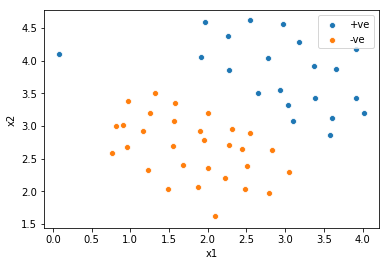

In [5]:
# Loading Mat file
mat=loadmat('./ex6data1.mat')
print(*mat.keys(),sep='\n')

X=mat['X']
y=mat['y'].astype(int)
y[y==0]=-1

data=pd.DataFrame({
    'x1':X[:,0],
    'x2':X[:,1],
    'y':y.reshape(-1)
})

print('TRAINING DATASET SHAPE : {0} X {1}'.format(*data.shape))
visualize(X,y)
data.sample(5)

As we can notice from the above image, that there is a positive outlier on the far left which will affect the SVM decision boundary. We will try using different values of the C parameter with SVMs.  
- C parameter is a positive value that controls the penalty for  misclassified training examples. 
- A large C parameter tells the SVM to try to classify all the examples correctly.
- C plays a role similar to $\frac{1}{\lambda}$ ,where $\lambda$ is the regularization parameter.

Out of 51 training samples, 3 are support vectors.


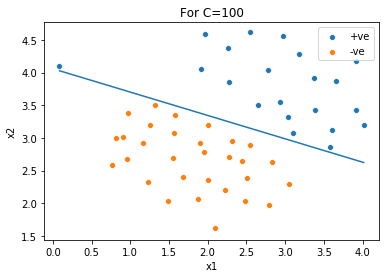

In [6]:
C=100
svm=SVM(C=C)
svm.fit(X,y)
print(f'Out of {y.shape[0]} training samples, {len(svm.alphas)} are support vectors.')
visualize(X,y,svm,title=f'For C={C}');

When $C=1$, we can see that the SVM puts the decision boundary in the gap between the two datasets amd misclassifies the outlier. This is an example of Soft Margin.

Out of 51 training samples, 12 are support vectors.


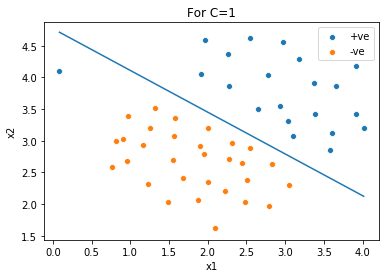

In [7]:
C=1
svm=SVM(C=C)
svm.fit(X,y.reshape(-1))
print(f'Out of {y.shape[0]} training samples, {len(svm.alphas)} are support vectors.')
visualize(X,y,svm,title=f'For C={C}');

When $C=100$, we can notice that the SVM now classifies every single sample correctly, but has a decision boundary that does not appear to be a natural fit. This is an example of Hard Margin.

#### 1.2&nbsp;&nbsp;&nbsp;&nbsp;SVM with Gaussian Kernel
Here, we will be using SVMs to do non-linear classification. In particular, we will be using SVMs with gaussian kernels on datasets that are not linearly separable.

##### 1.2.1&nbsp;&nbsp;&nbsp;&nbsp;Gaussian Kernel
$$k_{gaussian}(x_i,x_j)=exp(\frac{-1}{2\sigma^2}||x_i-x_j||^2)$$

We can think of the gaussian kernel as a similarity function that measures the "distance" between a pair of examples. The Gaussian kernel is parameterized by a bandwidth parameter $\sigma$, which determines how fast the similarity metric decreases to 0 as the examples are further apart.

##### 1.2.2&nbsp;&nbsp;&nbsp;&nbsp;Example Dataset 2

__header__
__version__
__globals__
X
y
TRAINING DATASET SHAPE : 863 X 3


,x1,x2,y
199,0.293779,0.810673,-1
415,0.623272,0.557749,1
852,0.890553,0.444737,1
627,0.349078,0.411404,-1
438,0.551843,0.522661,1


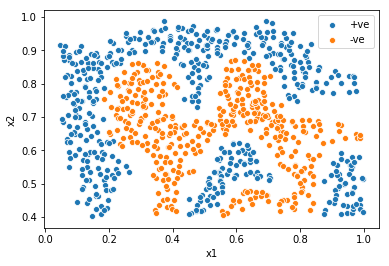

In [8]:
# Loading Mat file
mat=loadmat('./ex6data2.mat')
print(*mat.keys(),sep='\n')

X=mat['X']
y=mat['y'].astype(int)
y[y==0]=-1

data=pd.DataFrame({
    'x1':X[:,0],
    'x2':X[:,1],
    'y':y.reshape(-1)
})

print('TRAINING DATASET SHAPE : {0} X {1}'.format(*data.shape))
visualize(X,y)
data.sample(5)

We can observe that there is no linear boundary that separates the positive and negative samples for this dataset. However by using a Gaussian kernel with the SVM, we will be able to learn a non linear decision boundary that can perform reasonably well for this dataset.

Out of 863 training samples, 279 are support vectors.


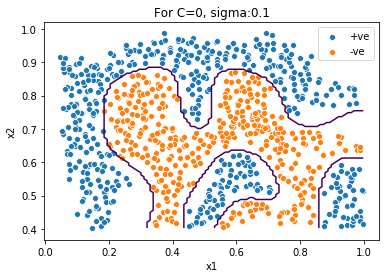

In [9]:
# Hard Margin SVM
C=0
svm=SVM(C=C,kernel=Kernels.gaussian)
svm.fit(X,y)
print(f'Out of {y.shape[0]} training samples, {len(svm.alphas)} are support vectors.')
visualize(X,y,svm,title=f'For C={C}, sigma:{Kernels.sigma}');

Out of 863 training samples, 187 are support vectors.


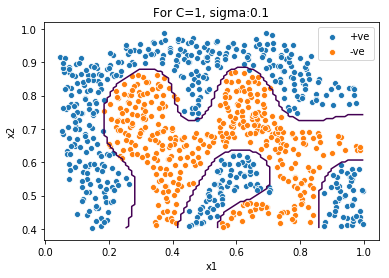

In [10]:
# Soft Margin SVM
C=1
svm=SVM(C=C,kernel=Kernels.gaussian)
svm.fit(X,y)
print(f'Out of {y.shape[0]} training samples, {len(svm.alphas)} are support vectors.')
visualize(X,y,svm,title=f'For C={C}, sigma:{Kernels.sigma}');

##### 1.2.3&nbsp;&nbsp;&nbsp;&nbsp;Example Dataset 3

In this part of the exercise, we are given a training and cross validation set. Our task is to determine the best $C$ and $\sigma$ parameter to use. For both $C$ and $\sigma$, we will try all the possible pairs for values (0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30) making a total of 64 different models.

__header__
__version__
__globals__
X
y
yval
Xval
TRAINING DATASET SHAPE : 211 X 3


,x1,x2,y
47,0.205069,-0.312865,-1
0,-0.158986,0.423977,1
76,0.223502,-0.371345,-1
167,-0.014171,-0.052924,-1
26,0.094470,-0.324561,-1


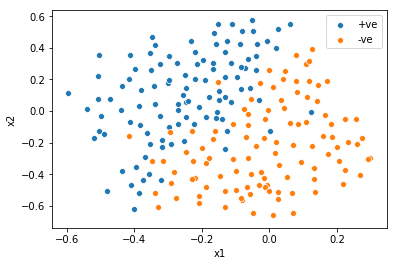

In [11]:
# Loading Mat file
mat=loadmat('./ex6data3.mat')
print(*mat.keys(),sep='\n')

X=mat['X']
y=mat['y'].astype(int)
y[y==0]=-1
# Validation set
Xval=mat['Xval']
yval=mat['yval'].astype(int)
yval[yval==0]=-1

data=pd.DataFrame({
    'x1':X[:,0],
    'x2':X[:,1],
    'y':y.reshape(-1)
})

print('TRAINING DATASET SHAPE : {0} X {1}'.format(*data.shape))
visualize(X,y)
data.sample(5)

In [12]:
def calculateAccuracy(h,y):
    '''Calculates the accuracy between the target and prediction'''
    m=y.shape[0]
    count=np.ones(h.shape)[h==y.reshape((m,1))].sum()
    accuracy=(count/m)*100
    return accuracy

In [13]:
values=[0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
C=sigma=None
accuracy=0

for i in values:
    for j in values:
        options={'sigma':j}
        svm=SVM(C=i,kernel=Kernels.gaussian,options=options)
        svm.fit(X,y)
        h=svm.predict(Xval)
        temp=calculateAccuracy(h,yval)
        if temp>accuracy:
            accuracy=temp
            C=i
            sigma=j
            print(f'For C={C:.2f} & sigma={sigma:.2f} ,\tValidation accuracy: {accuracy:.2f}%')            

For C=0.01 & sigma=0.01 ,	Validation accuracy: 48.50%
For C=0.01 & sigma=0.03 ,	Validation accuracy: 76.00%
For C=0.01 & sigma=0.10 ,	Validation accuracy: 95.50%
For C=0.30 & sigma=0.10 ,	Validation accuracy: 96.50%


Out of 211 training samples, 197 are support vectors.


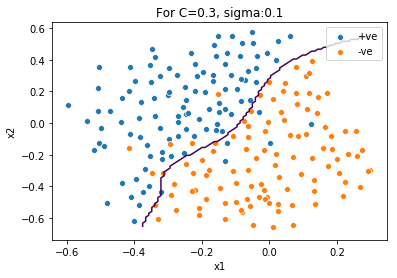

In [14]:
options={'sigma':sigma}
svm=SVM(C=C,kernel=Kernels.gaussian,options=options)
svm.fit(X,y)
h=svm.predict(X)
print(f'Out of {y.shape[0]} training samples, {len(svm.alphas)} are support vectors.')
visualize(X,y,svm,title=f'For C={C}, sigma:{sigma}');

### 2&nbsp;&nbsp;&nbsp;&nbsp;Spam Classification

Many email services today provide spam filters that are able to classify emails into spam and non-spam email with high accuracy. In this part of the exercise, we will use SVMs to build our own spam filter.  
We will  be training a classifier to classify whether a given email $x$, is a spam $(y=1)$ or non-spam $(y=-1)$. in particular we need to convert each email into a feature vector $x\epsilon R^{n}$.

#### 2.1&nbsp;&nbsp;&nbsp;&nbsp;Preprocessing Emails

Before starting on a machine learing task, it is usually insightful to take a look at examples from the dataset. Sample email shown above contains a URL, email address, numbers and dollar amounts. We should process these emails by normalizing these values, so that all the URLs, email address, amounts are treated the same. For example, URL can be replaced by 'httpaddr' to indicate that URL was present. This has the effect of letting the spam classifier make a classification based  on ANY url present rather than whether a specific URL was present. Few of the normalizzation techniques are mentioned below :

- **Lower-Casing** : This entire email should be converted into lowercase, so that the capitalization is ignored. (InDicate is treated as indicate)
- **Stripping HTML** : All the html tags are removed from the emails.
- **Normalizing URLs** : All the URLs are repalced by 'httpaddr'.
- **Normalizing Email addresses** : All email addresses are replaced by 'emailaddr'.
- **Normalizing Numbers** : All numbers are replaced by 'number'.
- **Normalizing Dollars** : All dollar signs are repalced by 'dollar'.
- **Word Stemming** : Words are reduced to their stemmed form. For example 'discounts', 'discount' and 'discounted' are all replaced with 'discount'. Sometimes the stemmer actually strips off the additional characters from the end.
- **Removal of non words** : Non words and punctuation should be removed. All white spaces have been trimmed to single space character.

##### 2.1.1&nbsp;&nbsp;&nbsp;&nbsp;Vocabulary List

After preprocessing the emails, we have a list of words for each email. the next step is to choose which words we would to use in our classifier and which we want to leave out. For this exercise, we have choosen only the most frequently occuring words as our set words considered for feature space. We will use the vocabulary list provided to us in the course.

**Note:** This vocabulary list was selected by choosing all words which occur at least a 100 times in the spam corpus, resulting in a list of 1899 words.

In [15]:
vocabulary=[]
with open('./vocabulary.txt') as f:
    for word in f.readlines():
        word=str(word).strip().replace('\t','')
        word=re.search(r'\D+',word).group(0)
        vocabulary.append(word)

In [16]:
from stemming.porter2 import stem

def processEmail(email,vocabulary):
    '''Preprocesses the body of an email and returns a list of indices
    of the words contained in the email'''
    wordIndices=[]
    # Stripping leading and trailing white spaces
    email=email.strip()
    # Removing newlines
    email=email.replace('\n',' ')    
    # Lower-casing
    email=email.lower()
    # Replace all numbers with 'number'
    email=re.sub(r'\d+','number',email)
    # Replace all URLs with 'httpaddr'
    email=re.sub(r"[\w!#$%&'*+-/=?^_`{|}~]+@[\w]+\.[\w]+",'httpaddr',email)
    # Replace all $ sign with 'dollar'
    email=re.sub(r'\$+','dollar',email)
    # Remove punctuation
    email=re.sub(r'[@\$/#\.\-:&\*\+=\[\]\?!\(\)\{\},''">_<;%]+','',email)
    # Word Stemming
    email=stem(email)
    # Lookup for word in vocabulary
    for word in email.split():
        try:
            index=vocabulary.index(word)
            wordIndices.append(index)
        except:
            pass
    print(email,end='\n\n')
    print(','.join([str(a) for a in wordIndices]))
    return wordIndices

**Sample Email 1**

In [17]:
with open('./spamSample1.txt') as f:
    sample=f.read()
print(sample)

Do You Want To Make $1000 Or More Per Week?

If you are a motivated and qualified individual - I 
will personally demonstrate to you a system that will 
make you $1,000 per week or more! This is NOT mlm.

Call our 24 hour pre-recorded number to get the 
details.  
000-456-789
I need people who want to make serious money.  Make 
the call and get the facts. 

Invest 2 minutes in yourself now!

000-456-789

Looking forward to your call and I will introduce you 
to people like yourself who
are currently making $10,000 plus per week!
000-456-789




**Processed Email 1 & Word Indices**

In [18]:
indices=processEmail(sample,vocabulary)

do you want to make dollarnumber or more per week  if you are a motivated and qualified individual  i  will personally demonstrate to you a system that will  make you dollarnumbernumber per week or more this is not mlm  call our number hour prerecorded number to get the  details   numbernumbernumber i need people who want to make serious money  make  the call and get the facts   invest number minutes in yourself now  numbernumbernumber  looking forward to your call and i will introduce you  to people like yourself who are currently making dollarnumbernumber plus per week numbernumbernumb

470,1892,1808,1698,996,1181,1063,1230,1826,809,1892,73,1851,1698,1892,1630,1664,1851,996,1892,1230,1826,1181,1063,876,1112,233,1190,1119,791,1119,1698,707,1665,1092,1843,1808,1698,996,996,1665,233,73,707,1665,868,1119,824,1895,1116,675,1698,1894,233,73,1851,1892,1698,955,1895,1843,1230,1826


**Sample Email 2**

In [19]:
with open('./spamSample2.txt') as f:
    sample=f.read()
print(sample)

Anyone knows how much it costs to host a web portal ?

Well, it depends on how many visitors youre expecting. This can be
anywhere from less than 10 bucks a month to a couple of $100. You
should checkout http://www.rackspace.com/ or perhaps Amazon EC2 if
youre running something big..
To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com


**Processed Email 2 & Word Indices**

In [20]:
indices=processEmail(sample,vocabulary)

anyone knows how much it costs to host a web portal   well it depends on how many visitors youre expecting this can be anywhere from less than number bucks a month to a couple of dollarnumber you should checkout httpwwwrackspacecom or perhaps amazon ecnumber if youre running something big to unsubscribe yourself from this mailing list send an email to httpaddr

793,1076,882,1698,789,1821,1830,882,1170,793,237,161,687,944,1662,1119,1061,1698,1161,1892,1509,1181,809,180,1698,1895,687,960,1476,70,529,1698,798


#### 2.2&nbsp;&nbsp;&nbsp;&nbsp;Extracting Features from Emails

We will now implement the feature extraction that converts each email into a vector in $R^{n}$. **We will be using $n=\#$ words in voabulary list.** Specifically, teh feature space $x_{i}\epsilon\{0,1\}$ for an email corresponds to whether the $i^{th}$ word in the dictionary occurs in the email. That is $x_{i}=1$ if the $i^{th}$ word in vocabulary is present in email and $x_j=0$ if the $j^{th}$ word in vocabulary is not present in email.

In [21]:
def extractFeatures(wordIndices,vocabulary):
    '''Creates a feature vector containing 0 and 1's out of word indices'''
    features=np.zeros(len(vocabulary))
    features[wordIndices]=1
    return features

In [22]:
features=extractFeatures(indices,vocabulary)
pd.DataFrame(pd.Series(features).value_counts(),columns=['count'])

,count
0.0,1872
1.0,27


#### 2.3&nbsp;&nbsp;&nbsp;&nbsp;Training SVM for Spam Classification
 
 In this part of the exercise, we will train our SVM classifier on preprocessed emails processed using same steps we followed above.

In [23]:
mat=loadmat('./spamTrain.mat')
m,n=mat['X'].shape
mat['y']=mat['y'].astype(int)
mat['y'][mat['y']==0]=-1

data=pd.DataFrame()
for i in range(n):
    data[f'x{i+1}']=mat['X'][:,i]
data['y']=mat['y']

valueCount=dict(data['y'].value_counts())
ratio=(valueCount[1]/m)*100
print('DATASET SHAPE : {0} X {1}'.format(*data.shape))
print(f'SPAM EMAIL RATIO : {ratio:.2f}%')
data.sample(5)

DATASET SHAPE : 4000 X 1900
SPAM EMAIL RATIO : 31.92%


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x1891,x1892,x1893,x1894,x1895,x1896,x1897,x1898,x1899,y
1142,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2051,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
3712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
3695,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-1


**Train and validation set split**

In [24]:
# Shuffle before split
data=data.sample(frac=1).reset_index(drop=True)

# 70/30 Split
mTrain=int((m*70)/100)
X=data.iloc[:mTrain,:-1].values
y=data.iloc[:mTrain,-1].values

Xval=data.iloc[mTrain:,:-1].values
yval=data.iloc[mTrain:,-1].values

**Training and Cross Validating**

In [25]:
values=[0.01, 0.03, 0.1,0.3]
C=None
accuracy=0
models={}

for i in values:
    svm=SVM(C=i,kernel=Kernels.linear)
    # Training
    svm.fit(X,y)
    models[i]=svm
    # Cross Validating
    h=svm.predict(Xval)
    temp=calculateAccuracy(h,yval)
    if temp>accuracy:
        accuracy=temp
        C=i
        print(f'For C={C:.2f} ,\tValidation accuracy: {temp:.2f}%')                

For C=0.01 ,	Validation accuracy: 97.00%
For C=0.03 ,	Validation accuracy: 97.75%


**Test Accuracy**

In [26]:
mat=loadmat('./spamTest.mat')
Xtest=mat['Xtest']
ytest=mat['ytest'].astype(int)
ytest[ytest==0]=-1

svm=models[C]
h=svm.predict(Xtest)
accuracy=calculateAccuracy(h,ytest)
print(f'For C={C:.2f} ,\tTest accuracy: {accuracy:.2f}%')                

For C=0.03 ,	Test accuracy: 99.20%


#### 2.4&nbsp;&nbsp;&nbsp;&nbsp;Top Predictors for Spam

To better understand how the spam classifier works, **we can inspect the parameter to see which words the classifier thinks are the most predictive of spam. In this exercise we will find the parameters with the largest positive values (SVM weights) in the classifier and display the corresponding word**. Thus, if an email contains words such as "guarantee", "remove", "click", and "free", it is likely to be classified as spam.

In [27]:
df=pd.DataFrame({'Word':vocabulary,'Weight':svm.w.reshape(-1)})
df=df.sort_values(by='Weight',ascending=False).reset_index(drop=True)
df

,Word,Weight
0,click,0.384208
1,basenumb,0.340995
2,remov,0.337922
3,our,0.316348
4,guarante,0.288738
5,here,0.233476
6,pleas,0.221139
7,free,0.207954
8,you,0.204145
9,hour,0.183123


<img src="images/meme2.jpg">